<a href="https://www.kaggle.com/code/tolikek/baseline-v1?scriptVersionId=91139093" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# НАЧАЛО РАБОТЫ

## Импорт библиотек

In [1]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## Настройка, подгрузка датасета

In [2]:
# зафиксировал random seed и версию пакетов, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
!pip freeze > requirements.txt

# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') 

# для корректной обработки признаков объединяем трейн и тест в один датасет (позже разделим)
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [3]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# ОБРАБОТКА ДАТАСЕТА

## ОТДЕЛЬНЫЙ ДАТАСЕТ С ОТЕЛЯМИ

## Выделение отелей

In [5]:
# признаки отеля, а не отзыва
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring']
hotels = data[hotel_cols].drop_duplicates().reset_index(drop=True)
hotels['hotel_id'] = hotels.index

In [6]:
# добавляем к основному датасету ID отеля, убираем признаки, относящиеся к отелю, из основного дата-сета
data = data.merge(hotels, on=hotel_cols, how='left')
data = data.drop(hotel_cols, axis=1)

In [7]:
hotels.head()

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,hotel_id
0,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,8.1,16670,904,0
1,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,8.6,5018,612,1
2,Alexandra Barcelona A DoubleTree by Hilton,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.161520,8.3,351,46,2
3,Hotel Principe Di Savoia,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,9.1,1543,241,3
4,Hotel Esther a,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,9.1,4687,834,4


## Признаки из географии отеля

In [8]:
# Выделяем страну, город и почтовый индекс из адреса отеля
hotels['city'] = hotels.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
hotels['country'] = hotels.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
hotels['zip'] = hotels.hotel_address.apply(lambda x: x.split()[-4] + ' ' + x.split()[-3] if x.endswith('United Kingdom') or x.endswith('Netherlands') else x.split()[-3])

In [9]:
# признаки с численностью населения страны и города отеля
сity_population = {
    'Paris': 2165423, 'London': 9002488, 'Milan': 1374582, 
    'Vienna': 1931830, 'Barcelona': 1636732, 'Amsterdam': 821752
}
hotels['сity_population'] = hotels['city'].map(сity_population)
country_population = {
    'United Kingdom':68481129,'Netherlands':17198147,'France':65515838,
    'Spain':46785044,'Italy':60313823,'Austria':9093258
}
hotels['country_population'] = hotels['country'].map(country_population)
hotels['%_city_pop_from_country_pop'] = hotels['сity_population'] / hotels['country_population']

In [10]:
# распределение отелей по странам
df_hotel_country = hotels.groupby('country')['hotel_name'].count()
fig = px.choropleth(
    locations=df_hotel_country.index,
    locationmode = "country names",
    scope='europe',
    color=np.log(df_hotel_country.values),
    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [11]:
# заполним пропуски средними координатами почтовых индексов
geo = hotels.groupby(['city', 'zip']).agg({'lat': 'mean', 'lng': 'mean'})#reset_index()
hotels = hotels.merge(geo, on=['city', 'zip'], suffixes=('', '_avg'))
hotels['lat'] = np.where(hotels.lat.isna(), hotels.lat_avg, hotels.lat)
hotels['lng'] = np.where(hotels.lng.isna(), hotels.lng_avg, hotels.lng)
hotels = hotels.drop(['lat_avg', 'lng_avg'], axis=1)

## Признак из названия отеля

In [12]:
# в названии отеля есть слово "отель"
def name_func(x):
    line = str(x)
    return int('hotel' in line.lower())
hotels['hotel_in_hotel_name'] = hotels['hotel_name'].apply(name_func)

## ОСНОВНОЙ ДАТАСЕТ С ОТЗЫВАМИ

## Объединяем датасеты

In [13]:
# добавляем к основному датасету признаки отеля
data = data.merge(hotels, on='hotel_id', how='left')

# кодируем зип с помощью LabelEncoder
data['zip'] = LabelEncoder().fit_transform(data['zip'])
data['city'] = LabelEncoder().fit_transform(data['city'])

# кодируем город с помощью dummies
data = pd.get_dummies(data, columns=['city'])

## Признаки из тэгов

In [14]:
# создал признаки самых частых тэгов, остальные в категорию other

# список уникальных тэгов
tag_list = list()
for line in data['tags']:
    line = line[1:]
    line = line[:-1]
    tag_list.extend(line.split(', '))
tag_set = set(tag_list)

# словарь с подсчетом частот тэгов
d = dict()
for c in tag_set:
    d[c] = tag_list.count(c)

df = pd.DataFrame(d.items(), columns=['tag', 'freq'])
df = df.sort_values(by='freq')
df1 = df.drop(df[df['freq'] < 10000].index)
df3 = pd.DataFrame({'tag':["' Other '"], 'freq':[df[df['freq'] < 10000]['freq'].sum()]})
df1 = df1.append(df3)
fig = px.histogram(df1, y='tag', x='freq')
fig.show()

tag_cols = list(df1['tag']) 

def func(x):
    x = x[1:-1]
    x = x.split(', ')
    ans = ''
    for tag in x:
        if tag in tag_cols:
            ans = ans + ' ' + tag
        else:
            ans = ans + " ' Other '"
    return ans
data['tags_upd'] = data['tags'].apply(func)

for tag in tag_cols:
    tag = tag[2:]
    tag = tag[:-2]
    data[tag] = data['tags_upd'].apply(lambda x: 1 if tag in x else 0)
    
data.drop(['tags', 'tags_upd'], inplace=True, axis=1)

## Признаки из национальности гостей

In [15]:
# признак, выделяющий постояльцев из той же страны
data['is_reviewer_from_same_country'] = data['country'].apply(lambda x: 0)
for i in range(data.shape[1]):
    data['is_reviewer_from_same_country'].iloc[i] = \
        int(data['country'].iloc[i].strip() == data['reviewer_nationality'].iloc[i].strip())

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# распределение гостей по национальностям
df_c = pd.DataFrame(data['reviewer_nationality'].value_counts())
fig = px.choropleth(
    locations=df_c.index,
    locationmode = "country names",
    color=np.log(df_c['reviewer_nationality']),
    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [17]:
# кодируем национальности постояльцев
df_c = df_c.drop(df_c[df_c['reviewer_nationality']<5000].index)
for nat in df_c.index:
    data['reviewer_nationality_'+nat] = data['reviewer_nationality'].apply(lambda x: 1 if x == nat else 0)
data['reviewer_nationality_other'] = data['reviewer_nationality'].apply(lambda x: 1 if x not in df_c.index else 0)

## Признаки из тональности отзыва

In [18]:
# доля _ слов в отзыве
data['%_positive_words_in_review'] = data['review_total_positive_word_counts'] / \
     (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
data['%_negative_words_in_review'] = data['review_total_negative_word_counts'] / \
     (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
data = data.drop(data[((data['%_positive_words_in_review'] > 1) \
     | (data['%_negative_words_in_review'] > 1)) & (data['sample'] == 1)].index) 

In [19]:
# отношение _ слов к общему числу отзывов данного гостя
data['#_positive_words_per_review'] = data['review_total_positive_word_counts'] / \
     data['total_number_of_reviews_reviewer_has_given']
data['#_negative_words_per_review'] = data['review_total_negative_word_counts'] / \
     data['total_number_of_reviews_reviewer_has_given']
data.drop(data[(data['#_positive_words_per_review'] + data['#_negative_words_per_review'] > 250) \
     & (data['sample'] == 1)].index, inplace=True)

In [20]:
# один из участников контеста применил класс SentimentIntensityAnalyzer из пакета nltk.sentiment.vader.
# Это уменьшило MAPE на пару процентов, показав высокую эффективность при решении задачи

## Признаки из даты

In [21]:
# признаки из даты, в порядке увеличения масштаба
data['review_date'] = pd.to_datetime(data['review_date'])
data['day'] = data['review_date'].dt.day
data['day_of_week'] = data['review_date'].dt.dayofweek
data['is_weekend'] = data['day'].apply(lambda x: 1 if x>4 else 0)
data['month'] = data['review_date'].dt.month
data['is_spring'] = data['month'].apply(lambda x: 1 if x in [3,4,5] else 0)
data['is_summer'] = data['month'].apply(lambda x: 1 if x in [6,7,8] else 0)
data['is_autumn'] = data['month'].apply(lambda x: 1 if x in [9,10,11] else 0)
data['is_winter'] = data['month'].apply(lambda x: 1 if x in [12,1,2] else 0)
data['year'] = data['review_date'].dt.year
data.drop(['review_date'], inplace=True, axis=1)

def since_func(x):
    string = str(x)
    return string.split()[0]
data['days_since_review'] = data['days_since_review'].apply(since_func)

In [22]:
# распределение reviewer_score в течение года. 
# Что примечательно, осенью рейтинги заметно ниже, а зимой и весной - выше
calendar = pd.pivot_table(data=data,index='month',values='reviewer_score',columns='day',aggfunc='median')
fig = px.imshow(calendar)
fig.show()

In [23]:
# распределение тональности текста в течение года
# Как видно на графике, доля положительных слов в отзыве немного падает осенью и растет зимой
calendar = pd.pivot_table(data=data,index='month',values='%_positive_words_in_review',columns='day',aggfunc='median')
fig = px.imshow(calendar)
fig.show()

## Удаление нечисловых признаков

In [24]:
# убираем признаки которые еще не успели обработать,  (dtypes "object")
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data = data.fillna(0)

# убираем внутренний идентификатор отеля и zip
data.drop(['hotel_id','zip'], axis = 1, inplace=True)

## Функции от признаков

In [25]:
for col in data:
    if col not in ['sample', 'reviewer_score'] and data[col].nunique() > 2:
        # полином не оправдал себя
        # data[col+"_^2"] = data[col]**2
        # data[col+"_^0.5"] = data[col]**0.5
        data[col+"_log"] = data[col].apply(lambda x: math.log(x+1))

## Нормализация

In [26]:
min_val, max_val = 0, 0
for col in data:
    if col not in ['sample', 'reviewer_score'] and data[col].nunique() > 2:
        min_val, max_val = data[col].min(), data[col].max()
        data[col] = data[col].apply(lambda x: 10*(x-min_val)/(max_val-min_val))

## Проверка на мультиколлинеарность

In [27]:
# корреляция признаков (оставляем только сильную связь для наглядности)
pivot = data.corr()
pivot = pivot.drop(['sample', 'reviewer_score'], axis=0)
pivot = pivot.drop(['sample', 'reviewer_score'], axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.85 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

fig = px.imshow(pivot)
fig.show()

In [28]:
# постараемся удалить как можно меньше признаков. Пробуем убрать как можно меньше признаков,
# но признаки с максимальной корреляцией в приоритете для удаления
counter = 0
for lower_bound in np.linspace(0.98, 0.85, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = data.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

Deleted 18 columns


# ОБУЧЕНИЕ МОДЕЛИ

In [29]:
# выделим трейн-тест-признаки-таргет
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
y = train_data.reviewer_score.values            
X = train_data.drop(['reviewer_score'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)

(128935, 73) (386332, 73) (386332, 72) (309065, 72) (77267, 72)


In [30]:
# в качестве модели возьмем случайный лес
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics # инструменты для оценки точности модели
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


In [31]:
# оцениваем точность прогноза
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 13.482969920961368


<AxesSubplot:>

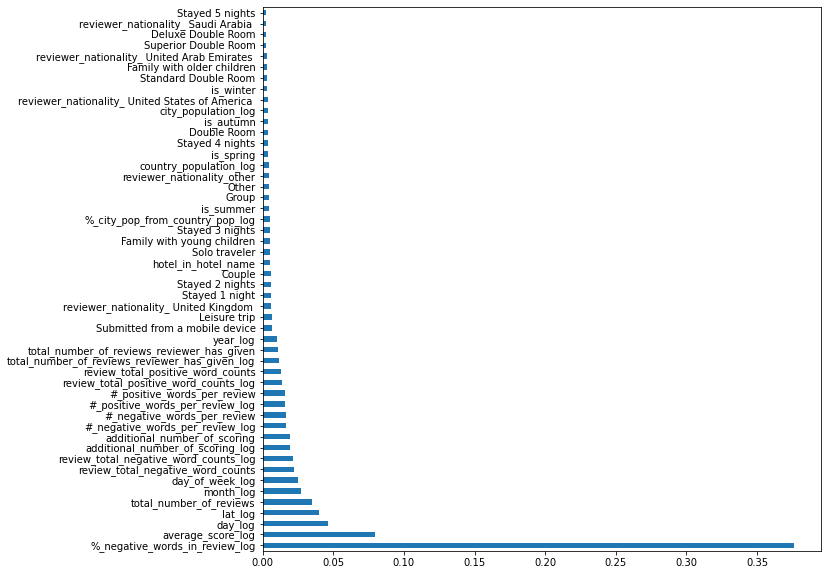

In [32]:
# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [33]:
# готовим ответ
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.5s finished
